In [1]:
%matplotlib inline


# 분류기(Classifier) 학습하기

지금까지 어떻게 신경망을 정의하고, 손실을 계산하며 또 가중치를 갱신하는지에
대해서 배웠습니다.

이제 아마도 이런 생각을 하고 계실텐데요,

## 데이터는 어떻게 하나요?

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를
이용하여 NumPy 배열로 불러오면 됩니다. 그 후 그 배열을 ``torch.*Tensor`` 로 변환합니다.

-  이미지는 Pillow나 OpenCV 같은 패키지가 유용합니다.
-  오디오를 처리할 때는 SciPy와 LibROSA가 유용하고요.
-  텍스트의 경우에는 그냥 Python이나 Cython을 사용해도 되고, NLTK나 SpaCy도
   유용합니다.

특별히 영상 분야를 위한 ``torchvision`` 이라는 패키지가 만들어져 있는데,
여기에는 ImageNet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한
데이터 로더(data loader), 즉 ``torchvision.datasets`` 과 이미지용 데이터 변환기
(data transformer), 즉 ``torch.utils.data.DataLoader`` 가 포함되어 있습니다.

이러한 기능은 엄청나게 편리하며, 매번 유사한 코드(boilerplate code)를 반복해서
작성하는 것을 피할 수 있습니다.

이 튜토리얼에서는 CIFAR10 데이터셋을 사용합니다. 여기에는 다음과 같은 분류들이
있습니다: '비행기(airplane)', '자동차(automobile)', '새(bird)', '고양이(cat)',
'사슴(deer)', '개(dog)', '개구리(frog)', '말(horse)', '배(ship)', '트럭(truck)'.
그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가
3개 채널(channel)의 색상으로 이뤄져 있다는 것을 뜻합니다.

## 이미지 분류기 학습하기

다음과 같은 단계로 진행해보겠습니다:

1. ``torchvision`` 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을
   불러오고, 정규화(nomarlizing)합니다.
2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용하여 신경망을 검사합니다.

### 1. CIFAR10을 불러오고 정규화하기

``torchvision`` 을 사용하여 매우 쉽게 CIFAR10을 불러올 수 있습니다.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다.
이를 [-1, 1]의 범위로 정규화된 Tensor로 변환합니다.

<div class="alert alert-info"><h4>Note</h4><p>만약 Windows 환경에서 BrokenPipeError가 발생한다면,
    torch.utils.data.DataLoader()의 num_worker를 0으로 설정해보세요.</p></div>



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [05:06<00:00, 555650.60it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


재미삼아 학습용 이미지 몇 개를 보겠습니다.



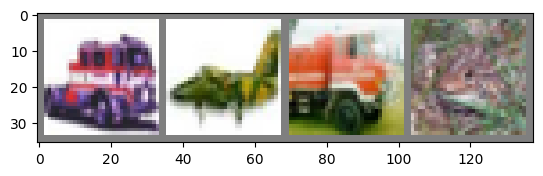

truck plane truck frog 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. 합성곱 신경망(Convolution Neural Network) 정의하기
3채널 이미지를 처리할 수 있도록 구현합니다.



In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3) # (3, 32, 32) --> (16, 30, 30)
        self.pool = nn.MaxPool2d(2) # (16, 30, 30) --> (16, 15, 15)
        self.conv2 = nn.Conv2d(16, 32, 3) # (16, 15, 15) --> (32, 13, 13)
        self.fc1 = nn.Linear(32*13*13, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x


net = Net()

### 3. 손실 함수와 Optimizer 정의하기
교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(momentum) 값을 갖는 SGD를 사용합니다.



In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-4)

### 4. 신경망 학습하기

이제 재미있는 부분이 시작됩니다.
단순히 데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)만 하면
됩니다.



In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()
        images, labels = data[0].to(device), data[1].to(device)
        pred = net(images)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # TODO

        # 변화도(Gradient) 매개변수를 0으로 만들고
        # TODO

        # 순전파 + 역전파 + 최적화를 한 후
        # TODO

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.148
[1,  4000] loss: 2.076
[1,  6000] loss: 2.030
[1,  8000] loss: 2.027
[1, 10000] loss: 2.008
[1, 12000] loss: 1.985
[2,  2000] loss: 1.942
[2,  4000] loss: 1.944
[2,  6000] loss: 1.942
[2,  8000] loss: 1.935
[2, 10000] loss: 1.909
[2, 12000] loss: 1.917
Finished Training


학습한 모델을 저장해보겠습니다:



In [14]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

PyTorch 모델을 저장하는 자세한 방법은 [여기](https://pytorch.org/docs/stable/notes/serialization.html)
를 참조해주세요.

### 5. 시험용 데이터로 신경망 검사하기

지금까지 학습용 데이터셋을 2회 반복하며 신경망을 학습시켰습니다.
신경망이 전혀 배운게 없을지도 모르니 확인해봅니다.

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인합니다.
만약 예측이 맞다면 샘플을 '맞은 예측값(correct predictions)' 목록에 넣겠습니다.

첫번째로 시험용 데이터를 좀 보겠습니다.



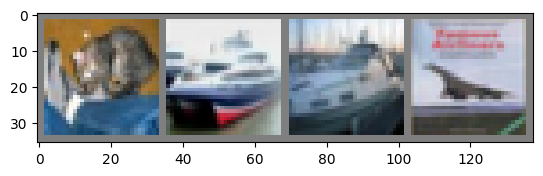

GroundTruth:  cat   ship  ship  plane


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

이제, 저장했던 모델을 불러오도록 하겠습니다 (주: 모델을 저장하고 다시 불러오는
작업은 여기에서는 불필요하지만, 어떻게 하는지 설명을 위해 해보겠습니다):



In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

좋습니다, 이제 이 예제들을 신경망이 어떻게 예측했는지를 보겠습니다:



In [17]:
outputs = net(images)

출력은 10개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이
나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것입니다.
따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다:



In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  ship  ship  plane plane


결과가 괜찮아보이네요.

그럼 전체 데이터셋에 대해서는 어떻게 동작하는지 보겠습니다.



In [19]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 24 %


(10가지 분류 중에 하나를 무작위로) 찍었을 때의 정확도인 10% 보다는 나아보입니다.
신경망이 뭔가 배우긴 한 것 같네요.

그럼 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보겠습니다:



In [20]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 77.2 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 86.2 %
Accuracy for class: truck is 83.2 %
